模型融合是比赛后期一个重要的环节，大体来说有如下的类型方式。

1.简单加权融合:
- 回归（分类概率）：算术平均融合（Arithmetic mean），几何平均融合（Geometric mean）；
- 分类：投票（Voting)
- 综合：排序融合(Rank averaging)，log融合  

2.stacking/blending:
- 构建多层模型，并利用预测结果再拟合预测。  

3.boosting/bagging（在xgboost，Adaboost,GBDT中已经用到）:
- 多树的提升方法

In [55]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

## 模型融合举例
### 回归问题的模型融合
#### 一般融合方法--简单加权平均

In [19]:
## 生成一些简单的样本数据，test_prei 代表第i个模型的预测值
test_pre1 = [1.2, 3.2, 2.1, 6.2]
test_pre2 = [0.9, 3.1, 2.0, 5.9]
test_pre3 = [1.1, 2.9, 2.2, 6.0]

# y_test_true 代表第模型的真实值
y_test_true = [1, 3, 2, 6] 

In [22]:
from sklearn import metrics

# 根据各模型的预测结果来计算MAE
print('Pred1 MAE:',metrics.mean_absolute_error(y_test_true, test_pre1))
print('Pred2 MAE:',metrics.mean_absolute_error(y_test_true, test_pre2))
print('Pred3 MAE:',metrics.mean_absolute_error(y_test_true, test_pre3))

Pred1 MAE: 0.1750000000000001
Pred2 MAE: 0.07499999999999993
Pred3 MAE: 0.10000000000000009


In [21]:
## 定义结果的加权平均函数，默认是每个模型预测结果的等权重求和
def Weighted_method(test_pre1, test_pre2, test_pre3, w=[1/3, 1/3, 1/3]):
    Weighted_result = w[0]*pd.Series(test_pre1) + w[1]*pd.Series(test_pre2) + w[2]*pd.Series(test_pre3)
    return Weighted_result

In [24]:
## 定义结果的加权平均函数：加权平均（在每个样本上，所有模型预测结果的加权平均值）

# 1 等权重
Weighted_pre = Weighted_method(test_pre1,test_pre2, test_pre3)   # 计算加权预测结果
print('Weighted_pre MAE:',metrics.mean_absolute_error(y_test_true, Weighted_pre))

# 2 定义不同权重
w = [0.3, 0.4, 0.3]   # 定义比重权值
Weighted_pre = Weighted_method(test_pre1,test_pre2, test_pre3, w)   # 计算加权预测结果
print('Weighted_pre MAE:', metrics.mean_absolute_error(y_test_true, Weighted_pre))

Weighted_pre MAE: 0.0666666666666666
Weighted_pre MAE: 0.05750000000000027


综上，可以发现加权结果相对于之前的结果是有提升的，这种我们称其为简单的加权平均

#### 特殊融合方法--mean平均和median平均

In [25]:
## 定义结果的加权平均函数：mean平均（在每个样本上，所有模型预测结果的均值）
def Mean_method(test_pre1, test_pre2, test_pre3):
    Mean_result = pd.concat([pd.Series(test_pre1),
                             pd.Series(test_pre2),
                             pd.Series(test_pre3)], axis=1).mean(axis=1)
    return Mean_result

In [26]:
Mean_pre = Mean_method(test_pre1, test_pre2, test_pre3)
print('Mean_pre MAE:', metrics.mean_absolute_error(y_test_true, Mean_pre))

Mean_pre MAE: 0.06666666666666693


In [27]:
## 定义结果的加权平均函数：median平均（在每个样本上，所有模型预测结果的中位数）
def Median_method(test_pre1, test_pre2, test_pre3):
    Median_result = pd.concat([pd.Series(test_pre1),
                               pd.Series(test_pre2),
                               pd.Series(test_pre3)], axis=1).median(axis=1)
    return Median_result

In [28]:
Median_pre = Median_method(test_pre1, test_pre2, test_pre3)
print('Median_pre MAE:', metrics.mean_absolute_error(y_test_true, Median_pre))

Median_pre MAE: 0.07500000000000007


#### stacking 融合
stacking是一种分层模型集成框架。简单来说 stacking 就是当用初始训练数据学习出若干个基学习器（初级学习器）后，将这几个学习器的**预测结果作为新的训练集（次训练集）**，来学习一个新的学习器（次级学习器或元学习器）。
- 以两层为例，第一层由多个基学习器组成，其输入为原始训练集，第二层的模型则是以第一层基学习器的输出作为训练集进行再训练，从而得到完整的stacking模型, stacking两层模型都使用了全部的训练数据。

In [29]:
from sklearn import linear_model
from sklearn import metrics
import pandas as pd 

def Stacking_method(train_reg1, train_reg2, train_reg3, y_train_true, 
                    test_pre1, test_pre2, test_pre3, model_L2= linear_model.LinearRegression()):
    train = pd.concat([pd.Series(train_reg1), 
                       pd.Series(train_reg2), 
                       pd.Series(train_reg3)], axis=1).values  
    
    print(train)   # 训练数据有4个数据，3个特征
    model_L2.fit(train, y_train_true)
    test = pd.concat([pd.Series(test_pre1),
                      pd.Series(test_pre2),
                      pd.Series(test_pre3)], axis=1).values    
    print(test)    # 测试数据也是4个数据，3个特征
    
    ## stacking的最后一层是简单线性回归，输入数据是前面每个模型对test数据(n_examples，n_features)的预测值的整合（n_examples, n_models) 
    Stacking_result = model_L2.predict(test)  # 模型输入不是原始特征，但模型输出仍是原始数据的预测值（n_examples,）
    return Stacking_result

In [30]:
## 生成样本数据：test_prei 代表第i个模型的预测值，y_test_true 代表test数据的真实值
train_reg1 = [3.2, 8.2, 9.1, 5.2]
train_reg2 = [2.9, 8.1, 9.0, 4.9]
train_reg3 = [3.1, 7.9, 9.2, 5.0]
y_train_true = [3, 8, 9, 5] 

##  train同样如此
test_pre1 = [1.2, 3.2, 2.1, 6.2]
test_pre2 = [0.9, 3.1, 2.0, 5.9]
test_pre3 = [1.1, 2.9, 2.2, 6.0]
y_test_true = [1, 3, 2, 6] 

In [32]:
model_L2= linear_model.LinearRegression()
Stacking_pre = Stacking_method(train_reg1, train_reg2, train_reg3, y_train_true,
                               test_pre1, test_pre2, test_pre3, model_L2)
print('\n Stacking_pre MAE:', metrics.mean_absolute_error(y_test_true, Stacking_pre))

[[3.2 2.9 3.1]
 [8.2 8.1 7.9]
 [9.1 9.  9.2]
 [5.2 4.9 5. ]]
[[1.2 0.9 1.1]
 [3.2 3.1 2.9]
 [2.1 2.  2.2]
 [6.2 5.9 6. ]]

 Stacking_pre MAE: 0.042134831460675204


In [8]:
Stacking_pre

array([0.97752809, 2.94382022, 1.92134831, 6.01123596])

可以发现模型结果相对于之前有进一步的提升，需要注意的一点是，**对于第二层Stacking的模型不宜选取的过于复杂**，这样会导致模型在训练集上过拟合，从而使得在测试集上并不能达到很好的效果。

### 分类问题的模型融合
#### Voting 投票法
##### 硬投票方法
Voting投票机制，分为软投票和硬投票两种，原理均采用少数服从多数的思想。

**硬投票法不区分模型结果的相对重要度**，最终投票数最多的类为最终被预测的类。

In [34]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn import datasets

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [39]:
iris = datasets.load_iris()
x = iris.data
y = iris.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

clf1 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=3, min_child_weight=2, 
                     subsample=0.7, colsample_bytree=0.6, objective='binary:logistic')
clf2 = RandomForestClassifier(n_estimators=50, max_depth=1, min_samples_split=4,
                              min_samples_leaf=63, oob_score=True)
clf3 = SVC(C=0.1)
eclf = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')
models = [clf1, clf2, clf3, eclf]
model_names = ['XGBoost', 'Random Forest', 'SVM', 'Stacking_hard']

for clf, model_name in zip(models, model_names):
    scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), model_name))

Accuracy: 0.960 (+/- 0.025) [XGBoost]
Accuracy: 0.333 (+/- 0.000) [Random Forest]
Accuracy: 0.947 (+/- 0.034) [SVM]
Accuracy: 0.947 (+/- 0.034) [Stacking_hard]


##### 软投票法
软投票法可以为不同模型设置不同权重，进而区别模型不同的重要度。

In [40]:
iris = datasets.load_iris()
x = iris.data
y = iris.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

clf1 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=3, min_child_weight=2, subsample=0.8, colsample_bytree=0.8, 
                     objective='binary:logistic')
clf2 = RandomForestClassifier(n_estimators=50, max_depth=1, min_samples_split=4, min_samples_leaf=63, oob_score=True)
clf3 = SVC(C=0.1, probability=True)
eclf = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('svc', clf3)], voting='soft', weights=[2, 1, 2])
models = [clf1, clf2, clf3, eclf]
model_names = ['XGBoost', 'Random Forest', 'SVM', 'Stacking_soft']

for clf, model_name in zip(models, model_names):
    scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), model_name))

Accuracy: 0.960 (+/- 0.025) [XGBoost]
Accuracy: 0.333 (+/- 0.000) [Random Forest]
Accuracy: 0.947 (+/- 0.034) [SVM]
Accuracy: 0.960 (+/- 0.025) [Stacking_soft]


#### Stacking 融合法--二分类
stacking是一种分层模型集成框架。
- 以两层为例，第一层由多个基学习器组成，其输入为原始训练集，第二层的模型则是以第一层基学习器的输出作为训练集进行再训练，从而得到完整的stacking模型, stacking两层模型都使用了全部的训练数据。  

5折交叉验证实现stacking

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
import pandas as pd

# 为了做二分类，取前100个数据，划分出训练集和测试集
iris = datasets.load_iris()
data = iris.data
target = iris.target
data = data[:100, :]
target = target[:100]
train_X, test_X, train_y, test_y = train_test_split(data, target, test_size=0.3, random_state=2020)

# 模型融合中使用到的各个单模型
clfs = [LogisticRegression(solver='lbfgs'),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)]

# 预测原始的输入特征，得到第二层融合模型的新的输入特征（融合特征）
dataset_ensemble_train = np.zeros((train_X.shape[0], len(clfs)))
dataset_ensemble_test = np.zeros((test_X.shape[0], len(clfs)))

# 训练第一层的模型，得到第二层的输入特征（dataset_ensemble_train、dataset_ensemble_test）
for j, clf in enumerate(clfs):
    print('训练第%d个模型' % j)
    # 训练第 j 个单模型
    dataset_ensemble_test_j = np.zeros((test_X.shape[0], 5))

    # 训练集再分层抽样进行五折交叉验证，依次划分成train和validation        
    n_splits = 5
    skf = StratifiedKFold(n_splits)
    skf = skf.split(train_X, train_y)
    # 5-Fold交叉训练，分出5组训练数据和验证数据，训练出5次（个）第j个单模型
    for i, (train, valid) in enumerate(skf):
        print('第%d个模型的第%d次训练' % (j, i))
        X_train, y_train, X_valid, y_valid = train_X[train], train_y[train], train_X[valid], train_y[valid]
        clf.fit(X_train, y_train)
        # 二分类问题，预测验证数据(X_valid)为正例的概率
        y_valid_pred = clf.predict_proba(X_valid)[:, 1]
        # valid是valid数据的index，train的融合特征的生成方式和test的不同，每次valid的预测数量为14，train_X的总数为70，5次填满
        dataset_ensemble_train[valid, j] = y_valid_pred
        # 5个模型，每个预测一下测试集数据(test_X)
        dataset_ensemble_test_j[:, i] = clf.predict_proba(test_X)[:, 1]
    # 用5-Fold交叉验证训练出的5个模型分别预测测试集数据，将其均值作为第二层融合模型的新的输入特征。
    dataset_ensemble_test[:, j] = dataset_ensemble_test_j.mean(1)
    # print(dataset_ensemble_train, '\n')
    # print(dataset_ensemble_test)
    print("val auc Score: %f\n\n" % roc_auc_score(test_y, dataset_ensemble_test[:, j]))

clf = LogisticRegression(solver='lbfgs')
clf.fit(dataset_ensemble_train, train_y)
y_predict = clf.predict_proba(dataset_ensemble_test)[:, 1]
print("Val auc Score of Stacking: %f" % (roc_auc_score(test_y, y_predict)))

训练第0个模型
第0个模型的第0次训练
第0个模型的第1次训练
第0个模型的第2次训练
第0个模型的第3次训练
第0个模型的第4次训练
val auc Score: 1.000000


训练第1个模型
第1个模型的第0次训练
第1个模型的第1次训练
第1个模型的第2次训练
第1个模型的第3次训练
第1个模型的第4次训练
val auc Score: 1.000000


训练第2个模型
第2个模型的第0次训练
第2个模型的第1次训练
第2个模型的第2次训练
第2个模型的第3次训练
第2个模型的第4次训练
val auc Score: 1.000000


训练第3个模型
第3个模型的第0次训练
第3个模型的第1次训练
第3个模型的第2次训练
第3个模型的第3次训练
第3个模型的第4次训练
val auc Score: 1.000000


训练第4个模型
第4个模型的第0次训练
第4个模型的第1次训练
第4个模型的第2次训练
第4个模型的第3次训练
第4个模型的第4次训练
val auc Score: 1.000000


Val auc Score of Stacking: 1.000000


注意：**skf必须放进外循环，不能放在循环外面**，因为skf只产生一个迭代器，一旦到达迭代器的末尾，就无法重复使用它。  如果skf放在循环外面（作者的原始方法是错的），除了第一轮是正常的，其他的都不对，都是没有执行中间的for（i）循环，直接跳过内层for循环，去执行循环后面的语句了 

reversed([1, 2, 3])，reversed()也是只产生一个迭代器

#### Blending融合法--二分类
Blending是一种和Stacking类似的多层模型融合的形式，其主要思路是把原始的训练集先分成两部分，比如70%的数据作为新的训练集，剩下30%的数据作为测试集。
- 在第一层，我们在这70%的数据上训练多个模型，然后去预测那30%数据的label，同时也预测test集的label。
- 在第二层，我们就直接用这30%数据在第一层预测的结果做为新特征继续训练，然后用test集第一层预测的label做特征，用第二层训练的模型做进一步预测

其优点在于：  
- 1.比stacking简单（因为不用进行k次的交叉验证来获得stacker feature）
- 2.避开了一个信息泄露问题：generlizers和stacker使用了不一样的数据集

缺点在于：  
- 1.使用了很少的数据（第二阶段的blender只使用training set 50%的数据）
- 2.blender可能会过拟合
- 3.不够稳健（stacking 使用多次的交叉验证会比较稳健） 

In [38]:
# 为了做二分类，取前100个数据，划分出训练集和测试集
iris = datasets.load_iris()
data = iris.data
target = iris.target
data = data[:100,:]
target = target[:100]
 
#模型融合中使用到的各个单模型
clfs = [LogisticRegression(solver='lbfgs'),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        #ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)]
 
# 将数据集划分为训练、测试两部分
train_X, test_X, train_y, test_y = train_test_split(data, target, test_size=0.3, random_state=2020)
# 再将训练数据集为 train，valid 两部分
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.5, random_state=2020)

# 与前面使用全部训练集来对第二层融合模型进行训练不同，这里使用训练集的部分数据（验证集）进行融合模型的训练
dataset_ensemble_valid = np.zeros((X_valid.shape[0], len(clfs)))
dataset_ensemble_test = np.zeros((test_X.shape[0], len(clfs)))

# 依次训练各个单模型，并对valid和验证集进行预测，生成第二层融合模型的输入特征
for j, clf in enumerate(clfs):
    print('第%d个模型的训练' % j)
    clf.fit(X_train, y_train)
    # 对于valid数据，直接用这 k 个模型的预测值作为新的特征
    dataset_ensemble_valid[:, j] = clf.predict_proba(X_valid)[:, 1]
    # 对于测试集，直接用这 k 个模型的预测值作为新的特征
    dataset_ensemble_test[:, j] = clf.predict_proba(test_X)[:, 1]
    print("val auc Score: %f\n" % roc_auc_score(test_y, dataset_test[:, j]))

# 第二层，模型融合
clf = GradientBoostingClassifier(learning_rate=0.02, subsample=0.5, max_depth=6, n_estimators=30)
clf.fit(dataset_ensemble_valid, y_valid)
y_test_pred = clf.predict_proba(dataset_ensemble_test)[:, 1]
print("Val auc Score of Blending: %f" % (roc_auc_score(test_y, y_test_pred)))

第0个模型的训练
val auc Score: 1.000000

第1个模型的训练
val auc Score: 1.000000

第2个模型的训练
val auc Score: 1.000000

第3个模型的训练
val auc Score: 1.000000

第4个模型的训练
val auc Score: 1.000000

Val auc Score of Blending: 1.000000


In [41]:
import itertools 
# itertools.product 用于求多个可迭代对象的笛卡尔积，生成坐标对
# product(A, B) 和 ((x,y) for x in A for y in B)的效果是一样的； product(A,repeat=3)等价于product(A,A,A)
grid = itertools.product([0,1], repeat=2)
for item in grid:
    print(item)

(0, 0)
(0, 1)
(1, 0)
(1, 1)


#### 基于mlxtend的Stacking融合--三分类
不需要再手动求出第二层融合模型的输入特征，sklearn 的 ensemble 算法里也有 StackingClassifier

Accuracy: 0.95 (+/- 0.02) [KNN]
Accuracy: 0.93 (+/- 0.05) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.95 (+/- 0.04) [Stacking]


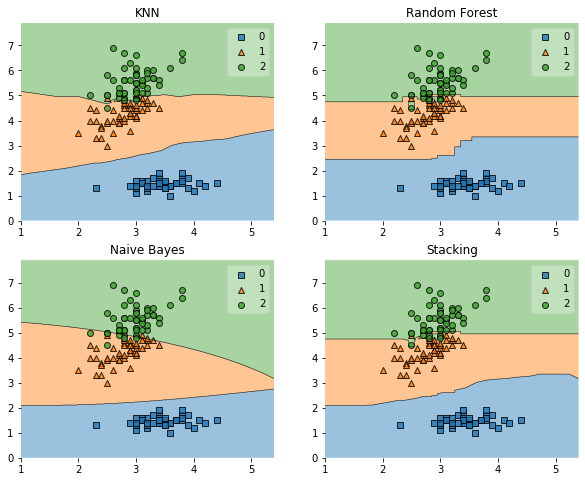

In [43]:
import warnings
warnings.filterwarnings('ignore')
import itertools # ？？？
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # ？？
%matplotlib inline

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score
# from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions  # https://github.com/rasbt/mlxtend


# 取两个特征，方便在坐标系上绘制决策函数
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = KNeighborsClassifier(n_neighbors=3)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr)
models = [clf1, clf2, clf3, sclf]
model_names = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking']

# 绘制多个子图：使用 GridSpec 自定义子图位置 https://blog.csdn.net/wizardforcel/article/details/54232788
fig = plt.figure(figsize=(10,8))
grid = itertools.product([0,1], repeat=2)
gs = gridspec.GridSpec(2,  2)

clf_cv_mean = []
clf_cv_std = []
for clf, model_name, grd in zip(models, model_names, grid):
    # 交叉验证，逐次训练单模型和stacking模型，并绘制出决策边界    
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" % (scores.mean(), scores.std(), model_name))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())       
    clf.fit(X, y)
    
    # 绘制某个位置的子图
    ax = plt.subplot( gs[grd[0], grd[1]] )
    # mlxtend可以自动获得模型的决策边界
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(model_name)
# 四个子图都在一个画板上，虽然绘制中插入的有别的print语句，但是最后仍可以一块显示
plt.show()

基模型用 'KNN', 'Random Forest', 'Naive Bayes'，然后在这基础上，次级模型加一个 'LogisticRegression'，模型测试效果有着很好的提升

#### 其它方法
将特征放进模型中预测，并将预测结果变换并作为新的特征加入原有特征中再经过模型预测结果 （Stacking变化）
（可以反复预测多次将结果加入最后的特征中）

In [45]:
def New_Ensemble_feature(train, test, train_y, clfs):
    train_ = np.zeros((train.shape[0], len(clfs*2)))
    test_ = np.zeros((test.shape[0], len(clfs*2)))
    
    # j 从 0 开始，依次训练各个单模型
    for j, clf in enumerate(clfs):
        # 使用第1个部分作为预测，第2部分来训练模型，获得其预测的输出作为第2部分的新特征。        
        clf.fit(train, train_y)
        y_train_pred = clf.predict(train)
        y_test_pred = clf.predict(test)

        # 每个模型预测一遍，生成新特征，填充数组，用作第二层的融合特征
        train_[:, j*2] = y_train_pred ** 2
        test_[:, j*2] = y_test_pred ** 2
        train_[:, j+1] = np.exp(y_train_pred)
        test_[:, j+1] = np.exp(y_test_pred)
    
    train_ = pd.DataFrame(train_)
    test_ = pd.DataFrame(test_)
    return train_, test_

In [46]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression

iris = datasets.load_iris()
data = iris.data
target = iris.target
data = data[:100,:]
target = target[:100]

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.3)
x_train = pd.DataFrame(x_train) 
x_test = pd.DataFrame(x_test)

# 模型融合中使用到的各个单模型
clfs = [LogisticRegression(),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)]

# 生成新特征
New_train, New_test = New_Ensemble_feature(x_train, x_test, y_train, clfs)

clf = LogisticRegression()
# clf = GradientBoostingClassifier(learning_rate=0.02, subsample=0.5, max_depth=6, n_estimators=30)
clf.fit(New_train, y_train)
y_test_pred = clf.predict_proba(New_test)[:, 1]
print("Val auc Score of stacking: %f" % (roc_auc_score(y_test, y_test_pred)))

Val auc Score of stacking: 1.000000


## 本次赛题的模型融合
### data_for_lr 数据

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gridspec
import itertools

from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn import datasets
from sklearn.model_selection import 
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, SparsePCA

In [70]:
# 数据有没有进行过缺失值填充？？
data_lr = pd.read_csv('processed data/data_for_lr1.gz')
data_lr.shape

(199037, 370)

In [57]:
# 要保证训练集做的特征工程，测试集基本上也要做
data_lr.head(3).append(data_lr.tail(3)).append(data_lr.sample(3))

,SaleID,kilometer,name,offerType,power,price,seller,train,v_0,v_1,v_10,v_11,v_12,v_13,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,model_0.0,model_1.0,model_2.0,model_3.0,model_4.0,model_5.0,model_6.0,model_7.0,model_8.0,model_9.0,model_10.0,model_11.0,model_12.0,model_13.0,model_14.0,model_15.0,model_16.0,model_17.0,model_18.0,model_19.0,model_20.0,model_21.0,model_22.0,model_23.0,model_24.0,model_25.0,model_26.0,model_27.0,model_28.0,model_29.0,model_30.0,model_31.0,model_32.0,model_33.0,model_34.0,model_35.0,model_36.0,model_37.0,model_38.0,model_39.0,model_40.0,model_41.0,model_42.0,model_43.0,model_44.0,model_45.0,model_46.0,model_47.0,model_48.0,model_49.0,model_50.0,model_51.0,model_52.0,model_53.0,model_54.0,model_55.0,model_56.0,model_57.0,model_58.0,model_59.0,model_60.0,model_61.0,model_62.0,model_63.0,model_64.0,model_65.0,model_66.0,model_67.0,model_68.0,model_69.0,model_70.0,model_71.0,model_72.0,model_73.0,model_74.0,model_75.0,model_76.0,model_77.0,model_78.0,model_79.0,model_80.0,model_81.0,model_82.0,model_83.0,model_84.0,model_85.0,model_86.0,model_87.0,model_88.0,model_89.0,model_90.0,model_91.0,model_92.0,model_93.0,model_94.0,model_95.0,model_96.0,model_97.0,model_98.0,model_99.0,model_100.0,model_101.0,model_102.0,model_103.0,model_104.0,model_105.0,model_106.0,model_107.0,model_108.0,model_109.0,model_110.0,model_111.0,model_112.0,model_113.0,model_114.0,model_115.0,model_116.0,model_117.0,model_118.0,model_119.0,model_120.0,model_121.0,model_122.0,model_123.0,model_124.0,model_125.0,model_126.0,model_127.0,model_128.0,model_129.0,model_130.0,model_131.0,model_132.0,model_133.0,model_134.0,model_135.0,model_136.0,model_137.0,model_138.0,model_139.0,model_140.0,model_141.0,model_142.0,model_143.0,model_144.0,model_145.0,model_146.0,model_147.0,model_148.0,model_149.0,model_150.0,model_151.0,model_152.0,model_153.0,model_154.0,model_155.0,model_156.0,model_157.0,model_158.0,model_159.0,model_160.0,model_161.0,model_162.0,model_163.0,model_164.0,model_165.0,model_166.0,model_167.0,model_168.0,model_169.0,model_170.0,model_171.0,model_172.0,model_173.0,model_174.0,model_175.0,model_176.0,model_177.0,model_178.0,model_179.0,model_180.0,model_181.0,model_182.0,model_183.0,model_184.0,model_185.0,model_186.0,model_187.0,model_188.0,model_189.0,model_190.0,model_191.0,model_192.0,model_193.0,model_194.0,model_195.0,model_196.0,model_197.0,model_198.0,model_199.0,model_200.0,model_201.0,model_202.0,model_203.0,model_204.0,model_205.0,model_206.0,model_207.0,model_208.0,model_209.0,model_210.0,model_211.0,model_212.0,model_213.0,model_214.0,model_215.0,model_216.0,model_217.0,model_218.0,model_219.0,model_220.0,model_221.0,model_222.0,model_223.0,model_224.0,model_225.0,model_226.0,model_227.0,model_228.0,model_229.0,model_230.0,model_231.0,model_232.0,model_233.0,model_234.0,model_235.0,model_236.0,model_237.0,model_238.0,model_239.0,model_240.0,model_241.0,model_242.0,model_243.0,model_244.0,model_245.0,model_246.0,model_247.0,brand_0,brand_1,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11,brand_12,brand_13,brand_14,brand_15,brand_16,brand_17,brand_18,brand_19,brand_20,brand_21,brand_22,brand_23,brand_24,brand_25,brand_26,brand_27,brand_28,brand_29,brand_30,brand_31,brand_32,brand_33,brand_34,brand_35,brand_36,brand_37,brand_38,brand_39,bodyType_0.0,bodyType_1.0,bodyType_2.0,bodyType_3.0,bodyType_4.0,bodyType_5.0,bodyType_6.0,bodyType_7.0,fuelType_0.0,fuelType_1.0,fuelType_2.0,fuelType_3.0,fuelType_4.0,fuelType_5.0,fuelType_6.0,gearbox_0.0,gearbox_1.0,notRepairedDamage_-,notRepairedDamage_0.0,notRepairedDamage_1.0,power_bin_0.0,power_bin_1.0,power_bin_2.0,power_bin_3.0,power_bin_4.0,power_bin_5.0,power_bin_6.0,power_bin_7.0,power_bin_8.0,power_bin_9.0,power_bin_10.0,power_bin_11.0,power_bin_12.0,power_bin_13.0,power_bin_14.0,power_bin_15.0,power_bin_16.0,po

数据中仍有缺失值

In [58]:
data_lr.isnull().sum(axis=0).sort_values(ascending=False)[:5]

price         50000
city          48645
used_time     15072
model_94.0        0
model_85.0        0
dtype: int64

In [69]:
data_lr.drop(['SaleID', 'name'], axis=1).shape

(199037, 368)

In [68]:
# loc通过行索引 "Index" 中的具体值来取行数据
data_lr.loc[data_lr.price.notnull()].shape

(149037, 370)

In [73]:
data_lr.loc[data_lr.price.notnull(), 'price']

0         1850.0
1         3600.0
2         6222.0
3         2400.0
4         5200.0
           ...  
149032    5900.0
149033    9500.0
149034    7500.0
149035    4999.0
149036    4700.0
Name: price, Length: 149037, dtype: float64

In [75]:
# 特征提取和数据集构建
data_lr = data_lr.drop(['SaleID', 'name'], axis=1)
x_train_lr = data_lr.loc[data_lr.price.notnull()]
x_test_lr = data_lr.loc[data_lr.price.isnull()]

# 第一种加[]，生成的是 df，而不是 series
# y_train_lr = data_lr.loc[data_lr.price.notnull(), ['price']]
y_train_lr = data_lr.loc[data_lr.price.notnull(), 'price']

In [ ]:
GridSearchCV返回的是MAE最大的模型

In [ ]:
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_absolute_error

def build_model_lr(x_train, y_train):
    reg_model = linear_model.LinearRegression()
    reg_model.fit(x_train, y_train)
    return reg_model

def build_model_ridge(x_train, y_train):
    # alphas=range(1,100,5)
    reg_model = linear_model.Ridge(alpha=0.8) 
    reg_model.fit(x_train, y_train)
    return reg_model

def build_model_lasso(x_train, y_train):
    reg_model = linear_model.LassoCV()
    reg_model.fit(x_train, y_train)
    return reg_model

def build_model_gbdt(x_train, y_train):
    estimator = GradientBoostingRegressor(loss='ls',subsample= 0.85,max_depth= 5,n_estimators = 100)
    param_grid = {'learning_rate': [0.05,0.08,0.1,0.2]
                 }
    gbdt = GridSearchCV(estimator, param_grid,cv=3)
    gbdt.fit(x_train, y_train)
    print(gbdt.best_params_)
    # print(gbdt.best_estimator_ )
    return gbdt

def build_model_xgb(x_train, y_train):
    # objective = 'reg:squarederror'
    model = xgb.XGBRegressor(n_estimators=120, learning_rate=0.08, gamma=0, subsample=0.8, colsample_bytree=0.9, max_depth=5) 
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train, y_train):
    estimator = lgb.LGBMRegressor(num_leaves=63, n_estimators = 100)
    param_grid = {'learning_rate': [0.01, 0.05, 0.1]
                 }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

#### 基于xgb 或 lgb 的方法
基于标签分层抽样的 5 折交叉验证

In [106]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

xgb = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, max_depth=7, n_jobs=3) 
# objective ='reg:squarederror'

lgb = lgb.LGBMRegressor(learning_rate=0.05, num_leaves=63, n_estimators=200, max_depth=20, n_jobs=3, objective='regression_l1')

scores_train_xgb, scores_val_xgb = [], []
scores_train_lgb, scores_val_lgb = [], []


# 基于标签分层抽样的 5 折交叉验证
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for train_ind, val_ind in sk.split(x_train_lr, y_train_lr):    
    train_x = x_train_lr.iloc[train_ind].values
    train_y = y_train_lr.iloc[train_ind]
    val_x = x_train_lr.iloc[val_ind].values
    val_y = y_train_lr.iloc[val_ind]
    
    # xgb
    xgb.fit(train_x, train_y)
    train_pred = xgb.predict(train_x)
    val_pred = xgb.predict(val_x)
    scores_train_xgb.append( mean_absolute_error(train_y, train_pred) )
    scores_val_xgb.append( mean_absolute_error(val_y, val_pred) )
    
    # lgb
    lgb.fit(train_x, train_y)
    train_pred_lgb = lgb.predict(train_x)
    val_pred_lgb = lgb.predict(val_x)
    scores_train_lgb.append( mean_absolute_error(train_y, train_pred_lgb) )
    scores_val_lgb.append( mean_absolute_error(val_y, val_pred_lgb) )    

[22:38:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:40:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:45:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:48:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train mae: 34.14872297076191
Val mae 52.15914155790449


为何mae这么低，y_train_lr 也没做对数变换啊？？

In [108]:
print('[xgb] Train mae:%.3f  Val mae:%.3f'% (np.mean(scores_train_xgb), np.mean(scores_val_xgb)))
print('[lgb] Train mae:%.3f  Val mae:%.3f'% (np.mean(scores_train_lgb), np.mean(scores_val_lgb)))

[xgb] Train mae:34.905  Val mae:45.203
[lgb] Train mae:55.204  Val mae:55.429


In [109]:
y_train_lr.min(),  y_train_lr.max()

(11.0, 99999.0)

##### 提交数据
保证预测的数据的顺序是一致的，ID是对照的，特别是 x_test_lr 和 x_test 之间

In [100]:
test = pd.read_csv('raw data/used_car_testA_20200313.csv', sep=' ')
sub = pd.read_csv('raw data/used_car_sample_submit.csv')

In [102]:
sub.head(3)

,SaleID,price
0,150000,0
1,150001,0
2,150002,0


In [87]:
test.head(3)

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,150000,66932,20111212,222.0,4,5.0,1.0,1.0,313,15.0,0.0,1440,0,0,20160329,49.593127,5.246568,1.001130,-4.122264,0.737532,0.264405,0.121800,0.070899,0.106558,0.078867,-7.050969,-0.854626,4.800151,0.620011,-3.664654
1,150001,174960,19990211,19.0,21,0.0,0.0,0.0,75,12.5,1.0,5419,0,0,20160404,42.395926,-3.253950,-1.753754,3.646605,-0.725597,0.261745,0.000000,0.096733,0.013705,0.052383,3.679418,-0.729039,-3.796107,-1.541230,-0.757055
2,150002,5356,20090304,82.0,21,0.0,0.0,0.0,109,7.0,0.0,5045,0,0,20160308,45.841370,4.704178,0.155391,-1.118443,-0.229160,0.260216,0.112081,0.078082,0.062078,0.050540,-4.926690,1.001106,0.826562,0.138226,0.754033


In [85]:
x_test_lr.head(3)

,kilometer,offerType,power,price,seller,train,v_0,v_1,v_10,v_11,v_12,v_13,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,model_0.0,model_1.0,model_2.0,model_3.0,model_4.0,model_5.0,model_6.0,model_7.0,model_8.0,model_9.0,model_10.0,model_11.0,model_12.0,model_13.0,model_14.0,model_15.0,model_16.0,model_17.0,model_18.0,model_19.0,model_20.0,model_21.0,model_22.0,model_23.0,model_24.0,model_25.0,model_26.0,model_27.0,model_28.0,model_29.0,model_30.0,model_31.0,model_32.0,model_33.0,model_34.0,model_35.0,model_36.0,model_37.0,model_38.0,model_39.0,model_40.0,model_41.0,model_42.0,model_43.0,model_44.0,model_45.0,model_46.0,model_47.0,model_48.0,model_49.0,model_50.0,model_51.0,model_52.0,model_53.0,model_54.0,model_55.0,model_56.0,model_57.0,model_58.0,model_59.0,model_60.0,model_61.0,model_62.0,model_63.0,model_64.0,model_65.0,model_66.0,model_67.0,model_68.0,model_69.0,model_70.0,model_71.0,model_72.0,model_73.0,model_74.0,model_75.0,model_76.0,model_77.0,model_78.0,model_79.0,model_80.0,model_81.0,model_82.0,model_83.0,model_84.0,model_85.0,model_86.0,model_87.0,model_88.0,model_89.0,model_90.0,model_91.0,model_92.0,model_93.0,model_94.0,model_95.0,model_96.0,model_97.0,model_98.0,model_99.0,model_100.0,model_101.0,model_102.0,model_103.0,model_104.0,model_105.0,model_106.0,model_107.0,model_108.0,model_109.0,model_110.0,model_111.0,model_112.0,model_113.0,model_114.0,model_115.0,model_116.0,model_117.0,model_118.0,model_119.0,model_120.0,model_121.0,model_122.0,model_123.0,model_124.0,model_125.0,model_126.0,model_127.0,model_128.0,model_129.0,model_130.0,model_131.0,model_132.0,model_133.0,model_134.0,model_135.0,model_136.0,model_137.0,model_138.0,model_139.0,model_140.0,model_141.0,model_142.0,model_143.0,model_144.0,model_145.0,model_146.0,model_147.0,model_148.0,model_149.0,model_150.0,model_151.0,model_152.0,model_153.0,model_154.0,model_155.0,model_156.0,model_157.0,model_158.0,model_159.0,model_160.0,model_161.0,model_162.0,model_163.0,model_164.0,model_165.0,model_166.0,model_167.0,model_168.0,model_169.0,model_170.0,model_171.0,model_172.0,model_173.0,model_174.0,model_175.0,model_176.0,model_177.0,model_178.0,model_179.0,model_180.0,model_181.0,model_182.0,model_183.0,model_184.0,model_185.0,model_186.0,model_187.0,model_188.0,model_189.0,model_190.0,model_191.0,model_192.0,model_193.0,model_194.0,model_195.0,model_196.0,model_197.0,model_198.0,model_199.0,model_200.0,model_201.0,model_202.0,model_203.0,model_204.0,model_205.0,model_206.0,model_207.0,model_208.0,model_209.0,model_210.0,model_211.0,model_212.0,model_213.0,model_214.0,model_215.0,model_216.0,model_217.0,model_218.0,model_219.0,model_220.0,model_221.0,model_222.0,model_223.0,model_224.0,model_225.0,model_226.0,model_227.0,model_228.0,model_229.0,model_230.0,model_231.0,model_232.0,model_233.0,model_234.0,model_235.0,model_236.0,model_237.0,model_238.0,model_239.0,model_240.0,model_241.0,model_242.0,model_243.0,model_244.0,model_245.0,model_246.0,model_247.0,brand_0,brand_1,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11,brand_12,brand_13,brand_14,brand_15,brand_16,brand_17,brand_18,brand_19,brand_20,brand_21,brand_22,brand_23,brand_24,brand_25,brand_26,brand_27,brand_28,brand_29,brand_30,brand_31,brand_32,brand_33,brand_34,brand_35,brand_36,brand_37,brand_38,brand_39,bodyType_0.0,bodyType_1.0,bodyType_2.0,bodyType_3.0,bodyType_4.0,bodyType_5.0,bodyType_6.0,bodyType_7.0,fuelType_0.0,fuelType_1.0,fuelType_2.0,fuelType_3.0,fuelType_4.0,fuelType_5.0,fuelType_6.0,gearbox_0.0,gearbox_1.0,notRepairedDamage_-,notRepairedDamage_0.0,notRepairedDamage_1.0,power_bin_0.0,power_bin_1.0,power_bin_2.0,power_bin_3.0,power_bin_4.0,power_bin_5.0,power_bin_6.0,power_bin_7.0,power_bin_8.0,power_bin_9.0,power_bin_10.0,power_bin_11.0,power_bin_12.0,power_bin_13.0,power_bin_14.0,power_bin_15.0,power_bin_16.0,power_bin_17.0

In [99]:
# 必须加上 .values，否则报错：ValueError: feature_names mismatch: ['f0'，'f1'] 与 ['kilometer', 'offerType']
# df 的columns 被重置了

y_submission_xgb = xgb.predict(x_test_lr.values)
y_submission_lgb = lgb.predict(x_test_lr.values)

In [104]:
sub['price'] = y_submission_xgb
sub.to_csv('sample_submit.csv')

### data_for_tree 数据

In [ ]:
data_tree = pd.read_csv('processed data/data_for_tree1.gz')
data_tree.shape